In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import lib, data, model
import graphs as gr
 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

<h5>Part 1: More data</h5>

In [327]:
# CV 5262 - FILE 1
# LA 691  | PE 1857 | SK 593 - FILE 2
# CF 3886 | RG 3772 | BS 2074 - FILE 3
# SO 3807 | DN 1310 | EX 1211 | PO 2582 - FILE 4
# LE 2890 |  LS 7000 - FILE 5
# NG 3149 |  YO 753 | BA 1056 - FILE 6
# M1 TO 50 - FILE 7
# Sheffield 2528 | Birmingham 4794 - FILE 8
# Liverpool 3300 ish - File 9

# postcodes = ['liverpool']

# df9 = data.getRegionalData(postcodes,'20200117',9)


In [29]:
# all_files = ["./data/london_rental_full.csv"]
all_files = []

for i in range(1,10):
    all_files.append("./data/20200117_rental%s.csv" %i)

# triming the original 56 columns to 17 useful columns
cols = ['bills_included','description',
        'details_url','first_published_date',
        'floor_plan', 'num_bathrooms','num_bedrooms','num_recepts',
        'furnished_state', 'property_type', 'rental_prices.shared_occupancy',
        'latitude', 'longitude','outcode',
        'listing_id','status',
        'rental_prices.per_month']
    
df_from_each_file = (pd.read_csv(f, usecols=cols) for f in all_files)
concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)


In [30]:
concatenated_df.shape

(56353, 17)

In [31]:
df = data.cleanData(concatenated_df)
df.shape

<h5>Part 2:EDA</h5>

In [10]:
region = df[(df['student'] == 1) | (df['shared_occu'] == 1)]

title = 'student'

grouped = data.getPerBedroomOvreview(region)

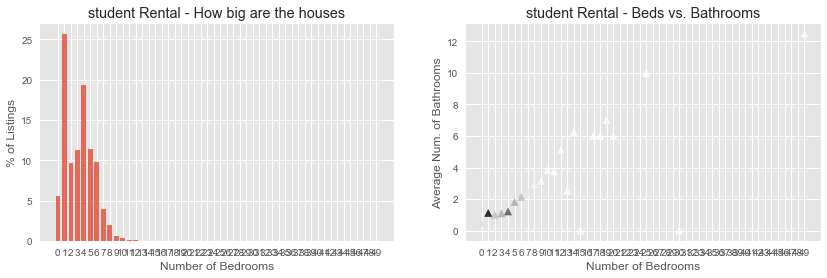

In [11]:
gr.areaOverview(grouped,title)

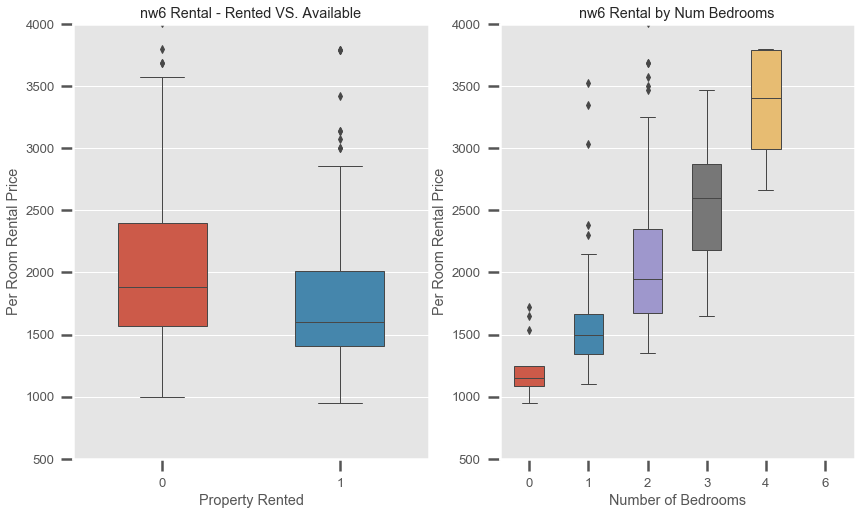

In [99]:
gr.rentPriceGraphs(region,title,'rent_price',500,4_000)

In [106]:
# gr.rentPriceBedBath(region,title,'rent_price',500,4_000)

In [107]:
data.getBathroomsByProperSize(region)

,num_bedrooms,num_bathrooms,count,proportion%,rent_pm
0,0,0,4,26.7,1083.0
1,0,1,11,73.3,1150.0
2,1,0,20,17.2,1462.5
3,1,1,93,80.2,1500.0
4,1,2,3,2.6,2150.0
5,2,0,28,17.1,954.0
6,2,1,59,36.0,838.0
7,2,2,77,47.0,1105.0
8,3,0,20,37.7,946.0
9,3,1,16,30.2,738.5


<h5>Part 3: Feature Engineer</h5>

In [38]:
region = df[(df['student'] == 1) | (df['shared_occu'] == 1)]
print(region.shape)

(17653, 19)


In [39]:
region['shortterm'] = region['description'].map(lambda x: 1 if 'short' in x else 0)
region.drop(region[region['shortterm'] == 1].index, inplace=True)

print(region.shape)

(15085, 20)


In [284]:
def classify_shared(x):
    
    if 'per room' in x:
        return 1
    elif 'room for rent' in x:
        return 1
    else:
        return 0
    

In [291]:
region['shared_occu']  = np.where((region['description'].map(lambda x: classify_shared(x)) ==1) | 
                                  (region['shared_occu'] == 1),1, df['shared_occu'])

In [289]:
# pd.set_option('display.max_colwidth', -1)
region[region['shared_occu']==1].shape
region[region['shared_occu']==1].shape

(1358, 22)

In [293]:
pd.set_option('display.max_colwidth', 200)
# region[(region['room']==1)]

In [294]:
df[(df['student'] == 1) | (df['shared_occu'] == 1)].shape

# print(region.shape)

(1725, 22)

<h5>Part 4: Modelling</h5>

In [40]:
trouble_postcodes = ['SW1','W1C','SW1A','W1K','W1J','W1','W1S','EN6','EC3R','SW1X']

for outcode in trouble_postcodes:
    region.drop(region[region['outcode'] == outcode].index, inplace=True)


X = region.drop(columns=['rent_price','listing_id','description','details_url',
                         'first_published_date','outcode','room_pm','shortterm','student'])
y = region['rent_price']

run = model.ModelTry(X,y)

In [41]:
## Perform a first naive linear regression model using only Continious Data Variables
lin_con, coef1, X_train, y_train = run.run_model(1, False, False)

Training r^2 %: 48.857
Testing r^2 %: 48.699
Training MSE (mil): 0.4964644112794771
Testing MSE (mil): 0.44734851653176555


In [42]:
## add in the categorical variables ---- OVERFITTING with outcode
lin_reg, coef2, X_train, y_train = run.run_model(2, False, False)

Training r^2 %: 50.73
Testing r^2 %: 50.338
Training MSE (mil): 0.478279497092516
Testing MSE (mil): 0.43305580618748984


In [43]:
## add in the polynomial interactions, see effects of overfitting here
lin_poly, coef3, X_train, y_train = run.run_model(2, False, True)

Training r^2 %: 55.943
Testing r^2 %: 55.194
Training MSE (mil): 0.42767521982728
Testing MSE (mil): 0.39070924035779386


Training r^2 %: 50.708
Testing r^2 %: 50.329
Training MSE (mil): 0.4785005478514518
Testing MSE (mil): 0.4331375413018965


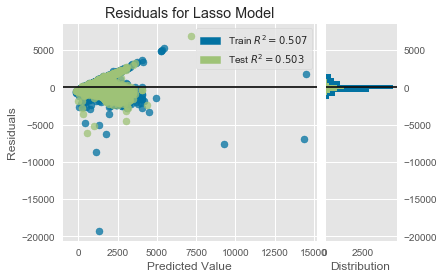

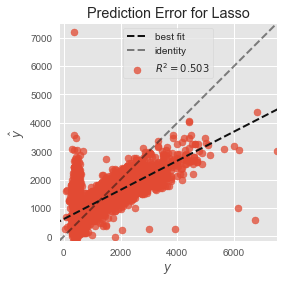

In [44]:
## use Lasso model
las, coef4, X_train, y_train = run.run_model(3, True, False)

In [45]:
coef4.sort_values('coef_abs', ascending=False).head()

,coef_value,coef_abs
num_bedrooms,685.245765,685.245765
property_type_Missing,-320.271361,320.271361
latitude,-102.490573,102.490573
property_type_Terrace,-99.084163,99.084163
property_type_Semi-detached house,89.612709,89.612709


In [176]:
# WORK OUT THE AVG PRICE PER OUTCODE & EXCLUDE THE EXTREMELY EXPENSIVE AREAS
# TRIM OUT THE SHORT TERM LETS


,bills_included,description,details_url,first_published_date,floor_plan,furnished_state,latitude,listing_id,longitude,num_bathrooms,num_bedrooms,num_recepts,outcode,property_type,rent_price,shared_occu,student,rented,room_pm,shortterm


In [224]:
region.groupby(['outcode'])\
    .agg({'room_pm':'median','rent_price':'median','listing_id':'size', 'num_bedrooms':'median'})\
    .sort_values('room_pm', ascending=False)

trouble_postcodes = ['SW1','W1C','SW1A','W1K','W1J','W1','W1S','EN6','EC3R','SW1X','WC1A','WC2A','W1D']

# grouped = region.groupby(['num_bedrooms']) \
#      .agg({'listing_id':'size', 'bills_included':'sum','floor_plan':'sum','room_pm':'median','num_bathrooms':'mean'}) \
#      .reset_index() \
#      .rename(columns={'listing_id':'count','num_bathrooms':'avg_baths'})